In [1]:
import os, glob
import pandas as pd
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

In [2]:
import typhon as tp
import AdditionalFunctions as af

In [3]:
# Set environmental variables. The ARTS path differ between my macbook and the company computer. 
if os.getcwd()[0:5] == '/User':
    tp.environ['ARTS_BUILD_PATH'] = '../../../../ARTS/arts-dev/build/'
    tp.environ['ARTS_INCLUDE_PATH'] = '../../../../ARTS/arts-dev/controlfiles/'
elif os.getcwd()[0:5] == '/home':
    tp.environ['ARTS_BUILD_PATH'] = '../../arts-dev/build/'
    tp.environ['ARTS_INCLUDE_PATH'] = '../../arts-dev/controlfiles/'

In [4]:
# Import Typhon retrieval packages. 
from typhon.retrieval.bmci import BMCI
from typhon.retrieval.mcmc import MCMC
from typhon.retrieval.qrnn import QRNN

Loading ARTS API from: ../../../../ARTS/arts-dev/build/src/libarts_api.so


Using TensorFlow backend.


In [5]:
# Assume WGS 1984 for the reference Ellipsoid.
R_eq = 6378137 # Earth's equatorial radius, in meters
iFlttn = 298.257223563 # Inverse flattening
R_polar = R_eq * (1-1/iFlttn) # Earth's polar radius
eccnty = (2/iFlttn - (1/iFlttn)**2)**0.5 # Eccentricity of the ellipsoid 

In [6]:
# Data month and day
dada = '07-16'

# Data hour of day
daho = '00'

# Files location
dain = os.path.join(os.getcwd(),dada)

# Observation/simulation time
TimeOfInterest = pd.Timestamp('2018-' + dada + ' ' + daho + ':00:00+0000',tz='UTC')

In [7]:
# Read in radimeters data.

# Read in brightness temperature data, contained in Level1 data.
f_radmtr_lv1 = glob.glob(dain + '/*lv1.csv')[0]
df_radmtr_lv1 = af.radiometrics()
df_radmtr_lv1.read_lv1_data(f_radmtr_lv1)

# Radiometer channels
radmtr_channels = df_radmtr_lv1.df.loc[:,'Ch22.000':'Ch58.800'].dropna(axis=1).columns.str.replace('Ch','')
radmtr_channels = radmtr_channels.values.astype(np.float64) * 1e9
# Save as .xml files. 
tp.arts.xml.save(radmtr_channels, './f_grid.xml')

True


In [8]:
# Radiometer observations (brightness temperatures) for the specific time 
# Tb_radmtr = df_radmtr_lv1.df.loc[(df_radmtr_lv1.df.DateTime - TimeOfInterest).abs().idxmin()] # Use the closest time.
# Take average 20 minutes or less before and after:
Tb_radmtr = df_radmtr_lv1.df.loc[(df_radmtr_lv1.df.DateTime - TimeOfInterest).abs() <= pd.Timedelta('20 minutes')]
Tb_radmtr = Tb_radmtr.loc[:,'Ch22.000':'Ch58.800'].dropna(axis=1).mean(axis=0).values.flatten()

In [9]:
# Read in radiometer's retrievals of atmospheric profiles, contained in Level2 data. 
f_radmtr_lv2 = glob.glob(dain + '/*lv2.csv')[0]
df_radmtr_lv2 = af.radiometrics()
df_radmtr_lv2.read_lv2_data(f_radmtr_lv2)

# Retrieval altitudes
radmtr_retrievedAlt = df_radmtr_lv2.df.loc[:,'0.00':'10.00'].columns.values.astype(np.float64) * 1000

# Retrieved temperatures
df_radmtr_lv2_T = df_radmtr_lv2.df.iloc[0::4]

# Retrieved RH
df_radmtr_lv2_RH = df_radmtr_lv2.df.iloc[3::4]

True


In [10]:
# Retrievals at the specific time 

# Retrieved temperatures
radmtr_retrievedT = df_radmtr_lv2_T.loc[(df_radmtr_lv2_T.DateTime - TimeOfInterest).abs() <= pd.Timedelta('20 minutes')]
radmtr_retrievedT = radmtr_retrievedT.loc[:,'0.00':'10.00'].dropna(axis=1).mean(axis=0).values.flatten()

# Retrieved RH
radmtr_retrievedRH = df_radmtr_lv2_RH.loc[(df_radmtr_lv2_RH.DateTime - TimeOfInterest).abs() <= pd.Timedelta('20 minutes')]
radmtr_retrievedRH = radmtr_retrievedRH.loc[:,'0.00':'10.00'].dropna(axis=1).mean(axis=0).values.flatten()

In [11]:
# Bosung radiometer's Gaussian optical antenna characteristics. 

# Full width at half maximum:
FWHM_22GHz = 6.3 ;
FWHM_30GHz = 4.9 ;
FWHM_51GHz = 2.5 ;
FWHM_59GHz = 2.4 ;
# Linear interpolation
FWHM_22to30GHz = np.interp(radmtr_channels[0:8], np.array([22, 30])*1e9, [FWHM_22GHz, FWHM_30GHz]) ;
FWHM_51to59GHz = np.interp(radmtr_channels[8:22], np.array([51, 59])*1e9, [FWHM_51GHz, FWHM_59GHz]) ;
FWHM = np.append(FWHM_22to30GHz, FWHM_51to59GHz)

# Antenna response
xwidth_si = 3; # Default value in ARTS. See "antenna_responseGaussian".
dx_si = 0.1; # Default values in ARTS. See "antenna_responseGaussian".
Zenith_angle = np.arange(-xwidth_si, xwidth_si + dx_si, dx_si) * FWHM_22GHz / (2*(2*np.log(2))**0.5)
anthenna_response = np.zeros((1, len(radmtr_channels), len(Zenith_angle), 1))
for i in range(len(radmtr_channels)):
    std_FWHM = FWHM[i]/(2*(2*np.log(2))**0.5)
    anthenna_response[0,i,:,0] = 1/(std_FWHM*(2*np.pi)**0.5)*np.exp(-4*np.log(2)*Zenith_angle**2/(FWHM[i]**2))

# Define ARTS variable "mblock_dlos_grid". 
mblock_dlos_grid = np.array([np.linspace(Zenith_angle[0],Zenith_angle[len(Zenith_angle)-1],20)]).T

In [12]:
# Save antenna_response as GriddedField4 .xml file. 
antenna_response_GF4 = tp.arts.griddedfield.GriddedField4()
antenna_response_GF4.name = 'Antenna response'
antenna_response_GF4.data = anthenna_response
antenna_response_GF4.grids = [['NaN'], radmtr_channels, Zenith_angle, np.array([0])]
antenna_response_GF4.gridnames = ['Polarisation', 'Frequency', 'Zenith angle', 'Azimuth angle']
tp.arts.xml.save(antenna_response_GF4, './antenna_response.xml')

# Save mblock_dlos_grid as .xml file. 
tp.arts.xml.save(mblock_dlos_grid, './mblock_dlos_grid.xml')

In [13]:
# Sensor LOS and geolocation 
tp.arts.xml.save(np.array([[0]]), './1D_sensor_los.xml')
tp.arts.xml.save(np.array([[0]]), './1D_sensor_pos.xml')

In [14]:
# Read in radiosondes data. 

fn_radsnd = "UPP_LV2_RS92-SGP_47258_" + TimeOfInterest.strftime('%Y%m%d%H%M') + ".txt"
f_radsnd = os.path.join(dain,fn_radsnd)
df_radsnd = pd.read_csv(f_radsnd, sep=",")
#print(*df_radsnd.time.values, sep='\n') # Print all values.
#print(df_radsnd.columns) % Data types. 
#print(df_radsnd.loc[1865:1868]) # Pressure duplicates

# Solicit useful variables. 
df_radsnd_useful = df_radsnd[['HGT', 'time', 'P', 'Temp', 'RH', 'MixR', 'Lon', 'Lat', 'Alt']]
df_radsnd_useful = df_radsnd_useful.dropna().reset_index().drop('index',axis=1)
df_radsnd_useful.loc[1:,] = df_radsnd_useful.loc[1:,].astype(float).values 
df_radsnd_useful_size = len(df_radsnd_useful.loc[:,'P'])

In [15]:
# Interpolate the data to fewer vertical grids. Use the nearest neighbor interpolation.
df_radsnd_useful_interp_size = 50;
df_radsnd_useful_interp = pd.DataFrame( 
    {'P' : 
     np.linspace(df_radsnd_useful.loc[1,'P'], df_radsnd_useful.loc[df_radsnd_useful_size-1,'P'], df_radsnd_useful_interp_size)} )
df_radsnd_useful_interp = df_radsnd_useful_interp.reindex(df_radsnd_useful.columns, axis=1)

# Interpolation
for i in range(df_radsnd_useful_interp_size):
    nearneigindex = (df_radsnd_useful.loc[1:,'P'] - df_radsnd_useful_interp.loc[i,'P']).astype(float).abs().idxmin()
    df_radsnd_useful_interp.loc[i,] = df_radsnd_useful.loc[nearneigindex,].astype('float')

# Unit conversions
df_radsnd_useful_interp.loc[:,'P'] = df_radsnd_useful_interp.loc[:,'P'] * 100
df_radsnd_useful_interp.loc[:,'Temp'] = df_radsnd_useful_interp.loc[:,'Temp'] + 273.15

In [16]:
# Necessary variables for ARTS simulations 
radsnd_P = df_radsnd_useful_interp.loc[:,'P'].values
radsnd_T = df_radsnd_useful_interp.loc[:,'Temp'].values
radsnd_RH = df_radsnd_useful_interp.loc[:,'RH'].values
radsnd_WaterVMR = tp.physics.relative_humidity2vmr(radsnd_RH * 0.01, radsnd_P, radsnd_T)
radsnd_HGT = df_radsnd_useful_interp.loc[:,'HGT'].values

In [17]:
# Read in LDAPS data. 

# Pressure (pres) data
fn_pres = "ldps_v070_erlo_pres_BSWO_h000." + TimeOfInterest.strftime('%Y%m%d%H') + ".txt"
f_pres = os.path.join(dain,fn_pres)
df_pres = pd.read_csv(f_pres, skiprows=0, 
                 names=['Index', '?(GridPosition)', 'Type', 'Pressure', 'Longitude', 'Latitude', 'Value'], 
                 sep=' mb:lon=|,lat=|,val=|:', 
                 engine='python')
pres_P = df_pres.loc[df_pres.Type=='HGT'].Pressure.values * 100
pres_GH = df_pres.loc[df_pres.Type=='HGT'].Value.values
pres_T = df_pres.loc[df_pres.Type=='TMP'].Value.values
pres_RH = df_pres.loc[df_pres.Type=='RH'].Value.values
pres_Lat = df_pres.Latitude[0]

# Surface (unis) data
fn_unis = "ldps_v070_erlo_unis_BSWO_h000." + TimeOfInterest.strftime('%Y%m%d%H') + ".txt"
f_unis = os.path.join(dain,fn_unis)
df_unis = pd.read_csv(f_unis, skiprows=0, 
                 names=['Index', '?(GridPosition)', 'Type', 'Altitude', 'Longitude', 'Latitude', 'Value'], 
                 sep=':lon=|,lat=|,val=|:',
                 engine='python')
unis_P = df_unis.loc[df_unis.Type=='PRMSL'].Value.values # df_unis.loc[df_unis.Type=='PRES'].Value.values
unis_T = df_unis.loc[(df_unis.Type=='TMP') & (df_unis.Altitude=='surface')].Value.values
unis_RH = df_unis.loc[df_unis.Type=='RH'].Value.values
unis_Alt = 0 # df_unis.loc[df_unis.Type=='DIST'].Value.values

In [18]:
# Prevent RH value = 0 by adding 0.01. Otherwise, retrievals produce errors. 
pres_RH[pres_RH == 0] = pres_RH[pres_RH == 0] + 0.0001

In [19]:
# Pressure

# Combine the unis and pres variables. 
LDAPS_P = np.append(unis_P, pres_P)

In [20]:
# Altitude

# Convert geopotential height to geometric height. 
# Reference (accessed 2018-07-02): 
# http://glossary.ametsoc.org/wiki/Geopotential_height
# http://glossary.ametsoc.org/wiki/Acceleration_of_gravity 
g0 = 9.80665 # Standard gravity at sea level 
g_lat = 0.01*(980.6160*(
    1 - 0.0026373*np.cos(np.pi/180 * 2*pres_Lat) + 0.0000059*(
        np.cos(np.pi/180 * 2*pres_Lat)**2))) # Sea-level gravity at given latitude
Cg = 0.01*(3.085462*(10**-4) + 2.27*(10**-7)*np.cos(np.pi/180*2*pres_Lat)) # The coefficient in the gravity equation. 

# Solve for geometric height, using the quadratic formula.
a = Cg/2
b = -g_lat
c = g0*pres_GH
pres_Alt = (-b - (b**2 - 4*a*c)**0.5)/(2*a)
# Here, the geopotential height is given based on 국지예보모델, so the calculated z field may be based on a spherical coordinates system.
# ARTS requires z field that is defined in terms of the geometrical altitude, 
# which is the distance between the ellipsoid's surface and the point along the line passing through the Earth's center and the point. 
# For now, assume that the difference between the two systems in this regard is negligible. 

# Combine the unis and pres variables. 
LDAPS_Z = np.append(unis_Alt, pres_Alt)

In [21]:
# Temperature

# Combine the unis and pres variables.
LDAPS_T = np.append(unis_T, pres_T)

In [22]:
# Water VMR

# Combine the unis and pres variables.
LDAPS_RH = np.append(unis_RH, pres_RH)

# Convert RH to VMR. 
LDAPS_WaterVMR = tp.physics.relative_humidity2vmr(LDAPS_RH * 0.01, LDAPS_P, LDAPS_T)

In [23]:
# Get rid of invalid values at the pressure levels higher than the surface pressure. 
flag_validpressurelevels = (LDAPS_P <= LDAPS_P[0])
LDAPS_P = LDAPS_P[flag_validpressurelevels]
LDAPS_Z = LDAPS_Z[flag_validpressurelevels]
LDAPS_T = LDAPS_T[flag_validpressurelevels]
LDAPS_RH = LDAPS_RH[flag_validpressurelevels]
LDAPS_WaterVMR = LDAPS_WaterVMR[flag_validpressurelevels]

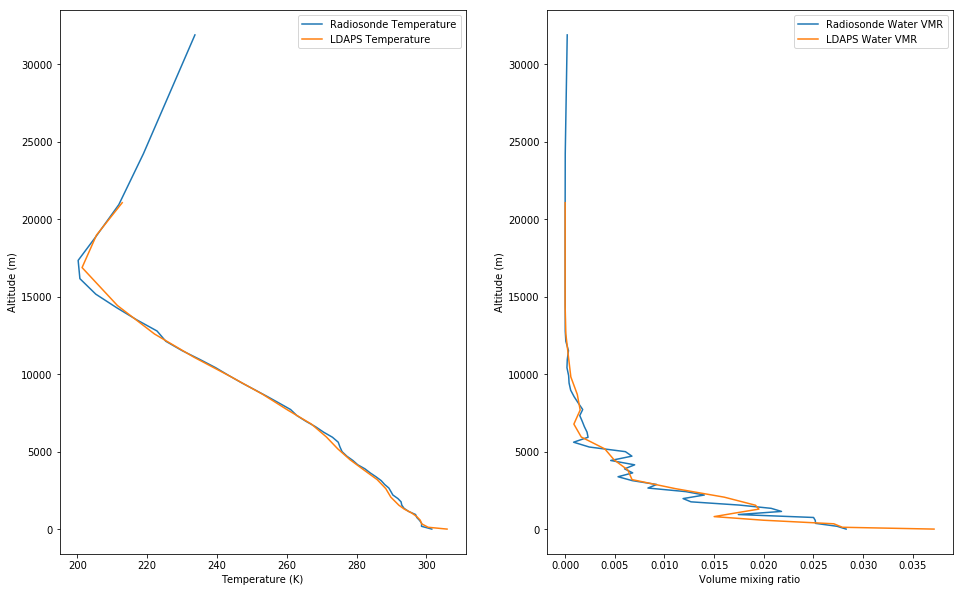

In [24]:
# Visualize the LDAPS and radiosondes data. 
plt.figure()

plt.subplot(1,2,1)
plt.plot(radsnd_T, radsnd_HGT, LDAPS_T, LDAPS_Z)
plt.xlabel('Temperature (K)')
plt.ylabel('Altitude (m)')
#plt.ylabel('Pressure (Pa)')
#plt.gca().invert_yaxis()
plt.legend(['Radiosonde Temperature', 'LDAPS Temperature'])

plt.subplot(1,2,2)
plt.plot(radsnd_WaterVMR, radsnd_HGT, LDAPS_WaterVMR, LDAPS_Z)
plt.xlabel('Volume mixing ratio')
plt.ylabel('Altitude (m)')
#plt.ylabel('Pressure (Pa)')
#plt.gca().invert_yaxis()
plt.legend(['Radiosonde Water VMR', 'LDAPS Water VMR'])

plt.gcf().set_size_inches(16,10)

# Save the figure.
# plt.savefig('./ARTSdata/' + TimeOfInterest.strftime('%Y_%m_%d_%H-%M-%S_') + 'T&WaterVMR' + '.png')

In [25]:
# ARTS forward model with the radiosonde data.
# Save the radiosonde variables as the input atmopsheric profiles. 

# Save pressure grid as .xml files.
tp.arts.xml.save(radsnd_P, './1D_p_grid.xml')

# Save z_field as GriddedField3 xml file. 
radsnd_z_field_GF3 = tp.arts.griddedfield.GriddedField3()
radsnd_z_field_GF3.data = np.reshape(radsnd_HGT,(len(radsnd_P),1,1))
radsnd_z_field_GF3.grids = [radsnd_P, np.array([0]), np.array([0])]
radsnd_z_field_GF3.gridnames = ['Pressure', 'Latitude', 'Longitude']
tp.arts.xml.save(radsnd_z_field_GF3, './1D.z.xml')

# Save t_field as GriddedField3 xml file. 
# Remove temperature values greater than 300 K, due to partition functions error in ARTS. 
# radsnd_T[radsnd_T > 300] = 300
radsnd_t_field_GF3 = tp.arts.griddedfield.GriddedField3()
radsnd_t_field_GF3.data = np.reshape(radsnd_T,(len(radsnd_P),1,1))
radsnd_t_field_GF3.grids = [radsnd_P, np.array([0]), np.array([0])]
radsnd_t_field_GF3.gridnames = ['Pressure', 'Latitude', 'Longitude']
tp.arts.xml.save(radsnd_t_field_GF3, './1D.t.xml')

# Save Water VMR as GriddedField3 xml file. 
radsnd_VMR_H2O_GF3 = tp.arts.griddedfield.GriddedField3()
radsnd_VMR_H2O_GF3.data = np.reshape(radsnd_WaterVMR,(len(radsnd_P),1,1))
radsnd_VMR_H2O_GF3.grids = [radsnd_P, np.array([0]), np.array([0])]
radsnd_VMR_H2O_GF3.gridnames = ['Pressure', 'Latitude', 'Longitude']
tp.arts.xml.save(radsnd_VMR_H2O_GF3, './1D.H2O.xml')

# Run ARTS. 
tp.arts.run_arts(controlfile='./ClearSky_1D_ARTSvdev.arts');

# ARTS forward model results. 
Tb_radsnd = tp.arts.xml.load("./ClearSky_1D_Tb.xml")

In [26]:
# ARTS forward model with the LDAPS data.
# Save the LDAPS variables as the input atmopsheric profiles. 

# Save pressure grid as .xml files.
tp.arts.xml.save(LDAPS_P, './1D_p_grid.xml')

# Save z_field as GriddedField3 xml file. 
LDAPS_z_field_GF3 = tp.arts.griddedfield.GriddedField3()
LDAPS_z_field_GF3.data = np.reshape(LDAPS_Z,(len(LDAPS_P),1,1))
LDAPS_z_field_GF3.grids = [LDAPS_P, np.array([0]), np.array([0])]
LDAPS_z_field_GF3.gridnames = ['Pressure', 'Latitude', 'Longitude']
tp.arts.xml.save(LDAPS_z_field_GF3, './1D.z.xml')

# Save t_field as GriddedField3 xml file. 
# Remove temperature values greater than 300 K, due to partition functions error in ARTS. 
# LDAPS_t[LDAPS_t > 300] = 300
LDAPS_t_field_GF3 = tp.arts.griddedfield.GriddedField3()
LDAPS_t_field_GF3.data = np.reshape(LDAPS_T,(len(LDAPS_P),1,1))
LDAPS_t_field_GF3.grids = [LDAPS_P, np.array([0]), np.array([0])]
LDAPS_t_field_GF3.gridnames = ['Pressure', 'Latitude', 'Longitude']
tp.arts.xml.save(LDAPS_t_field_GF3, './1D.t.xml')

# Save Water VMR as GriddedField3 xml file. 
LDAPS_VMR_H2O_GF3 = tp.arts.griddedfield.GriddedField3()
LDAPS_VMR_H2O_GF3.data = np.reshape(LDAPS_WaterVMR,(len(LDAPS_P),1,1))
LDAPS_VMR_H2O_GF3.grids = [LDAPS_P, np.array([0]), np.array([0])]
LDAPS_VMR_H2O_GF3.gridnames = ['Pressure', 'Latitude', 'Longitude']
tp.arts.xml.save(LDAPS_VMR_H2O_GF3, './1D.H2O.xml')

# Run ARTS. 
tp.arts.run_arts(controlfile='./ClearSky_1D_ARTSvdev.arts');

# ARTS forward model results. 
Tb_LDAPS = tp.arts.xml.load("./ClearSky_1D_Tb.xml")

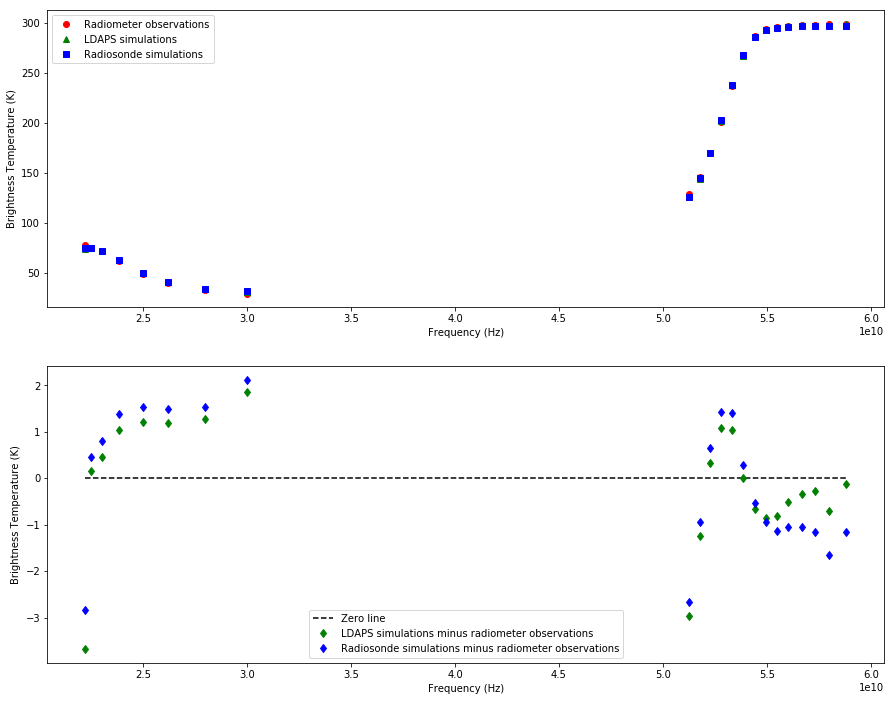

In [27]:
# Compare brightness temperatures between the radiometer observations, the LDAPS simulations, and the radiosonde simulations. 
plt.figure()

plt.subplot(2,1,1)
plt.plot(radmtr_channels, Tb_radmtr, 'ro', 
         radmtr_channels, Tb_LDAPS, 'g^', 
         radmtr_channels, Tb_radsnd, 'bs')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Brightness Temperature (K)')
plt.legend(['Radiometer observations', 'LDAPS simulations', 'Radiosonde simulations'])

plt.subplot(2,1,2)
plt.plot(radmtr_channels, np.zeros(radmtr_channels.shape),'k--', 
        radmtr_channels, Tb_LDAPS - Tb_radmtr, 'gd', 
        radmtr_channels, Tb_radsnd - Tb_radmtr, 'bd')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Brightness Temperature (K)')
plt.legend(['Zero line', 'LDAPS simulations minus radiometer observations', 'Radiosonde simulations minus radiometer observations'])

plt.gcf().set_size_inches(15,12)

# Save the figure.
# plt.savefig('./ARTSdata/' + TimeOfInterest.strftime('%Y_%m_%d_%H-%M-%S_') + 'ForwardModels_v_Observations' + '.png')

In [28]:
plt.close('all')

In [29]:
# Save the input, output, and comparison files in names with the corresponding time.

# LDAPS inputs
tp.arts.xml.save(LDAPS_P, './ARTSdata/' + TimeOfInterest.strftime('%Y_%m_%d_%H-%M-%S_') + 'LDAPS' + '_p_grid.xml')
tp.arts.xml.save(LDAPS_z_field_GF3, './ARTSdata/' + TimeOfInterest.strftime('%Y_%m_%d_%H-%M-%S_') + 'LDAPS' + '.z.xml')
tp.arts.xml.save(LDAPS_t_field_GF3, './ARTSdata/' + TimeOfInterest.strftime('%Y_%m_%d_%H-%M-%S_') + 'LDAPS' + '.t.xml')
tp.arts.xml.save(LDAPS_VMR_H2O_GF3, './ARTSdata/' + TimeOfInterest.strftime('%Y_%m_%d_%H-%M-%S_') + 'LDAPS' + '.H2O.xml')

# Radiosonde inputs
tp.arts.xml.save(radsnd_P, './ARTSdata/' + TimeOfInterest.strftime('%Y_%m_%d_%H-%M-%S_') + 'radsnd' + '_p_grid.xml')
tp.arts.xml.save(radsnd_z_field_GF3, './ARTSdata/' + TimeOfInterest.strftime('%Y_%m_%d_%H-%M-%S_') + 'radsnd' + '.z.xml')
tp.arts.xml.save(radsnd_t_field_GF3, './ARTSdata/' + TimeOfInterest.strftime('%Y_%m_%d_%H-%M-%S_') + 'radsnd' + '.t.xml')
tp.arts.xml.save(radsnd_VMR_H2O_GF3, './ARTSdata/' + TimeOfInterest.strftime('%Y_%m_%d_%H-%M-%S_') + 'radsnd' + '.H2O.xml')

# Radiometer retrievals for comparisons 
tp.arts.xml.save(radmtr_retrievedAlt, './ARTSdata/' + TimeOfInterest.strftime('%Y_%m_%d_%H-%M-%S_') + 'radmtr' + '_retrievedAlt.xml')
tp.arts.xml.save(radmtr_retrievedT, './ARTSdata/' + TimeOfInterest.strftime('%Y_%m_%d_%H-%M-%S_') + 'radmtr' + '_retrievedT.xml')
tp.arts.xml.save(radmtr_retrievedRH, './ARTSdata/' + TimeOfInterest.strftime('%Y_%m_%d_%H-%M-%S_') + 'radmtr' + '_retrievedRH.xml')

# Save LDAPS and radiosonde RH variables for use in Atmlab.
# Save LDAPS RH as GriddedField3 xml file. 
LDAPS_RH_GF3 = tp.arts.griddedfield.GriddedField3()
LDAPS_RH_GF3.data = np.reshape(LDAPS_RH,(len(LDAPS_P),1,1))
LDAPS_RH_GF3.grids = [LDAPS_P, np.array([0]), np.array([0])]
LDAPS_RH_GF3.gridnames = ['Pressure', 'Latitude', 'Longitude']
tp.arts.xml.save(LDAPS_RH_GF3, './ARTSdata/' + TimeOfInterest.strftime('%Y_%m_%d_%H-%M-%S_') + 'LDAPS' + '_RH.xml')
# Save radiosonde RH as GriddedField3 xml file. 
radsnd_RH_GF3 = tp.arts.griddedfield.GriddedField3()
radsnd_RH_GF3.data = np.reshape(radsnd_RH,(len(radsnd_P),1,1))
radsnd_RH_GF3.grids = [radsnd_P, np.array([0]), np.array([0])]
radsnd_RH_GF3.gridnames = ['Pressure', 'Latitude', 'Longitude']
tp.arts.xml.save(radsnd_RH_GF3, './ARTSdata/' + TimeOfInterest.strftime('%Y_%m_%d_%H-%M-%S_') + 'radsnd' + '_RH.xml')

In [30]:
# Brightness temperatures: radiometer observations, LDAPS and radiosonde simulations
tp.arts.xml.save(Tb_radmtr, './ARTSdata/' + TimeOfInterest.strftime('%Y_%m_%d_%H-%M-%S_') + 'radmtr' + '_Tb.xml')
tp.arts.xml.save(Tb_LDAPS, './ARTSdata/' + TimeOfInterest.strftime('%Y_%m_%d_%H-%M-%S_') + 'LDAPS' + '_Tb.xml')
tp.arts.xml.save(Tb_radsnd, './ARTSdata/' + TimeOfInterest.strftime('%Y_%m_%d_%H-%M-%S_') + 'radsnd' + '_Tb.xml')

In [31]:
# Extend the LDAPS data in the upper layers to match the maximum altitude of the radiosonde data. 

if radsnd_HGT[-1] > LDAPS_Z[-1]:
    Z_extadd = np.linspace(LDAPS_Z[-1], radsnd_HGT[-1], 5)
    f = sp.interpolate.interp1d(np.array([LDAPS_Z[-1], radsnd_HGT[-1]]), np.array([LDAPS_P[-1], radsnd_P[-1]]))
    P_extadd = f(Z_extadd) 
    f = sp.interpolate.interp1d(np.array([LDAPS_Z[-1], radsnd_HGT[-1]]), np.array([LDAPS_T[-1], radsnd_T[-1]]))
    T_extadd = f(Z_extadd)
    f = sp.interpolate.interp1d(np.array([LDAPS_Z[-1], radsnd_HGT[-1]]), np.array([LDAPS_WaterVMR[-1], radsnd_WaterVMR[-1]]))
    WaterVMR_extadd = f(Z_extadd) 
    RH_extadd = tp.physics.vmr2relative_humidity(WaterVMR_extadd, P_extadd, T_extadd) * 100

    LDAPS_Z_ext = np.append(LDAPS_Z, Z_extadd[1:])
    LDAPS_P_ext = np.append(LDAPS_P, P_extadd[1:])
    LDAPS_T_ext = np.append(LDAPS_T, T_extadd[1:])
    LDAPS_RH_ext = np.append(LDAPS_RH, RH_extadd[1:])
    LDAPS_WaterVMR_ext = np.append(LDAPS_WaterVMR, WaterVMR_extadd[1:])

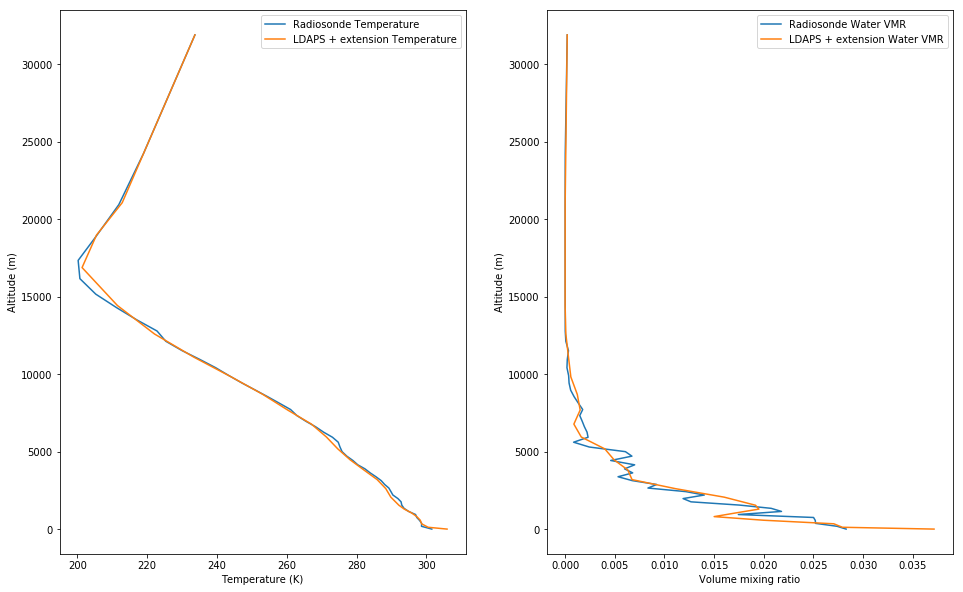

In [32]:
# Visualize the LDAPS extended and radiosondes data. 
if radsnd_HGT[-1] > LDAPS_Z[-1]:
    plt.figure()

    plt.subplot(1,2,1)
    plt.plot(radsnd_T, radsnd_HGT, LDAPS_T_ext, LDAPS_Z_ext)
    plt.xlabel('Temperature (K)')
    plt.ylabel('Altitude (m)')
    #plt.ylabel('Pressure (Pa)')
    #plt.gca().invert_yaxis()
    plt.legend(['Radiosonde Temperature', 'LDAPS + extension Temperature'])

    plt.subplot(1,2,2)
    plt.plot(radsnd_WaterVMR, radsnd_HGT, LDAPS_WaterVMR_ext, LDAPS_Z_ext)
    plt.xlabel('Volume mixing ratio')
    plt.ylabel('Altitude (m)')
    #plt.ylabel('Pressure (Pa)')
    #plt.gca().invert_yaxis()
    plt.legend(['Radiosonde Water VMR', 'LDAPS + extension Water VMR'])

    plt.gcf().set_size_inches(16,10)
    
    # Save the figure.
    # plt.savefig('./ARTSdata/' + TimeOfInterest.strftime('%Y_%m_%d_%H-%M-%S_') + 'T&WaterVMR_LDAPSextended' + '.png')

In [33]:
# ARTS forward model with the LDAPS extended data.
# Save the LDAPS extended variables as the input atmopsheric profiles. 

if radsnd_HGT[-1] > LDAPS_Z[-1]:
    # Save pressure grid as .xml files.
    tp.arts.xml.save(LDAPS_P_ext, './1D_p_grid.xml')

    # Save z_field as GriddedField3 xml file. 
    LDAPS_z_field_GF3 = tp.arts.griddedfield.GriddedField3()
    LDAPS_z_field_GF3.data = np.reshape(LDAPS_Z_ext,(len(LDAPS_P_ext),1,1))
    LDAPS_z_field_GF3.grids = [LDAPS_P_ext, np.array([0]), np.array([0])]
    LDAPS_z_field_GF3.gridnames = ['Pressure', 'Latitude', 'Longitude']
    tp.arts.xml.save(LDAPS_z_field_GF3, './1D.z.xml')

    # Save t_field as GriddedField3 xml file. 
    # Remove temperature values greater than 300 K, due to partition functions error in ARTS. 
    # LDAPS_t[LDAPS_t > 300] = 300
    LDAPS_t_field_GF3 = tp.arts.griddedfield.GriddedField3()
    LDAPS_t_field_GF3.data = np.reshape(LDAPS_T_ext,(len(LDAPS_P_ext),1,1))
    LDAPS_t_field_GF3.grids = [LDAPS_P_ext, np.array([0]), np.array([0])]
    LDAPS_t_field_GF3.gridnames = ['Pressure', 'Latitude', 'Longitude']
    tp.arts.xml.save(LDAPS_t_field_GF3, './1D.t.xml')

    # Save Water VMR as GriddedField3 xml file. 
    LDAPS_VMR_H2O_GF3 = tp.arts.griddedfield.GriddedField3()
    LDAPS_VMR_H2O_GF3.data = np.reshape(LDAPS_WaterVMR_ext,(len(LDAPS_P_ext),1,1))
    LDAPS_VMR_H2O_GF3.grids = [LDAPS_P_ext, np.array([0]), np.array([0])]
    LDAPS_VMR_H2O_GF3.gridnames = ['Pressure', 'Latitude', 'Longitude']
    tp.arts.xml.save(LDAPS_VMR_H2O_GF3, './1D.H2O.xml')

    # Run ARTS. 
    tp.arts.run_arts(controlfile='./ClearSky_1D_ARTSvdev.arts');

    # ARTS forward model results. 
    Tb_LDAPS_ext = tp.arts.xml.load("./ClearSky_1D_Tb.xml")

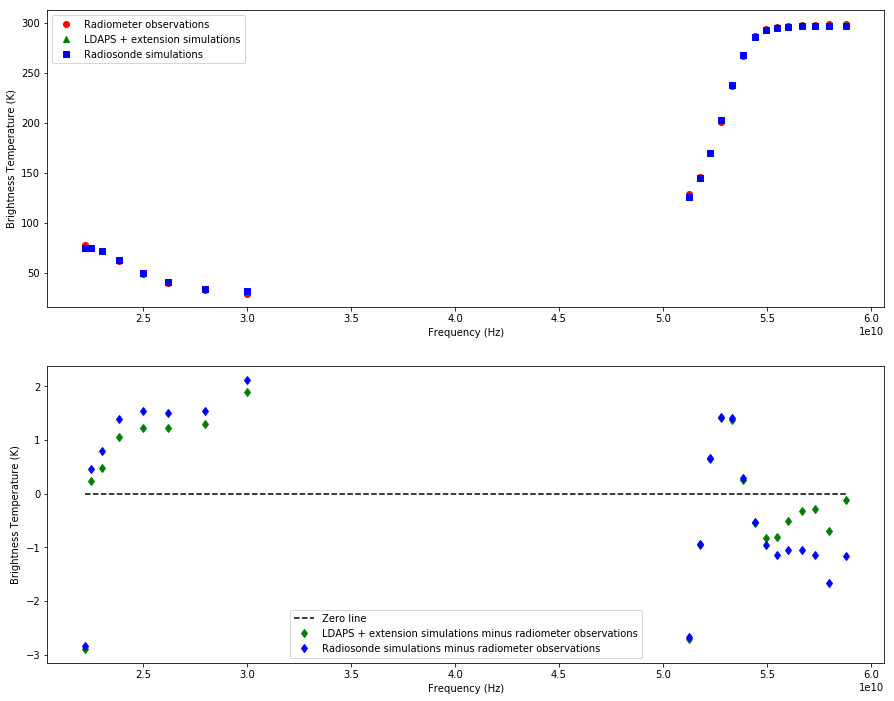

In [34]:
# Compare brightness temperatures between the radiometer observations, the LDAPS simulations, and the radiosonde simulations. 
if radsnd_HGT[-1] > LDAPS_Z[-1]:
    plt.figure()

    plt.subplot(2,1,1)
    plt.plot(radmtr_channels, Tb_radmtr, 'ro', 
             radmtr_channels, Tb_LDAPS_ext, 'g^', 
             radmtr_channels, Tb_radsnd, 'bs')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Brightness Temperature (K)')
    plt.legend(['Radiometer observations', 'LDAPS + extension simulations', 'Radiosonde simulations'])

    plt.subplot(2,1,2)
    plt.plot(radmtr_channels, np.zeros(radmtr_channels.shape),'k--', 
            radmtr_channels, Tb_LDAPS_ext - Tb_radmtr, 'gd', 
            radmtr_channels, Tb_radsnd - Tb_radmtr, 'bd')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Brightness Temperature (K)')
    plt.legend(['Zero line', 'LDAPS + extension simulations minus radiometer observations', 'Radiosonde simulations minus radiometer observations'])

    plt.gcf().set_size_inches(15,12)

    # Save the figure.
    # plt.savefig('./ARTSdata/' + TimeOfInterest.strftime('%Y_%m_%d_%H-%M-%S_') + 'ForwardModels_v_Observations_LDAPSextended' + '.png')

In [35]:
# ARTS forward model and retrieval with OEM in development version: 

# Save the radiosonde variables as the input atmopsheric profiles. 
#
# Save pressure grid as .xml files.
tp.arts.xml.save(radsnd_P, './1D_p_grid.xml')
#
# Save z_field as GriddedField3 xml file. 
radsnd_z_field_GF3 = tp.arts.griddedfield.GriddedField3()
radsnd_z_field_GF3.data = np.reshape(radsnd_HGT,(len(radsnd_P),1,1))
radsnd_z_field_GF3.grids = [radsnd_P, np.array([0]), np.array([0])]
radsnd_z_field_GF3.gridnames = ['Pressure', 'Latitude', 'Longitude']
tp.arts.xml.save(radsnd_z_field_GF3, './1D.z.xml')
#
# Save t_field as GriddedField3 xml file. 
# Remove temperature values greater than 300 K, due to partition functions error in ARTS. 
# radsnd_T[radsnd_T > 300] = 300
radsnd_t_field_GF3 = tp.arts.griddedfield.GriddedField3()
radsnd_t_field_GF3.data = np.reshape(radsnd_T,(len(radsnd_P),1,1))
radsnd_t_field_GF3.grids = [radsnd_P, np.array([0]), np.array([0])]
radsnd_t_field_GF3.gridnames = ['Pressure', 'Latitude', 'Longitude']
tp.arts.xml.save(radsnd_t_field_GF3, './1D.t.xml')
#
# Save Water VMR as GriddedField3 xml file. 
radsnd_VMR_H2O_GF3 = tp.arts.griddedfield.GriddedField3()
radsnd_VMR_H2O_GF3.data = np.reshape(radsnd_WaterVMR,(len(radsnd_P),1,1))
radsnd_VMR_H2O_GF3.grids = [radsnd_P, np.array([0]), np.array([0])]
radsnd_VMR_H2O_GF3.gridnames = ['Pressure', 'Latitude', 'Longitude']
tp.arts.xml.save(radsnd_VMR_H2O_GF3, './1D.H2O.xml')
#
# Save radiometer L1 brightness temperatures. 
tp.arts.xml.save(Tb_radmtr, './Tb_radmtrL1.xml')
#
# Save a priori covariance matrices (SX) for the retrieval quanitities (temperature and water VMR).
CovMat_radsnd_WaterVMR = af.covmat1d_from_cfun( radsnd_P, np.array([ radsnd_P, 0.5 * radsnd_WaterVMR ]).T, 'lin', 0.5, 0, np.log10 );
CovMat_radsnd_T = af.covmat1d_from_cfun( radsnd_P, 4, 'lin', 0.5, 0, np.log10 );
tp.arts.xml.save(CovMat_radsnd_T, './SX_T.xml')
tp.arts.xml.save(CovMat_radsnd_WaterVMR, './SX_WaterVMR.xml')

# Run ARTS. 
tp.arts.run_arts(controlfile='./ClearSky_1D_OEM_ARTSvdev.arts')

# ARTS forward model results. 
Tb_radsnd = tp.arts.xml.load("./ClearSky_1D_OEM_Tb.xml")

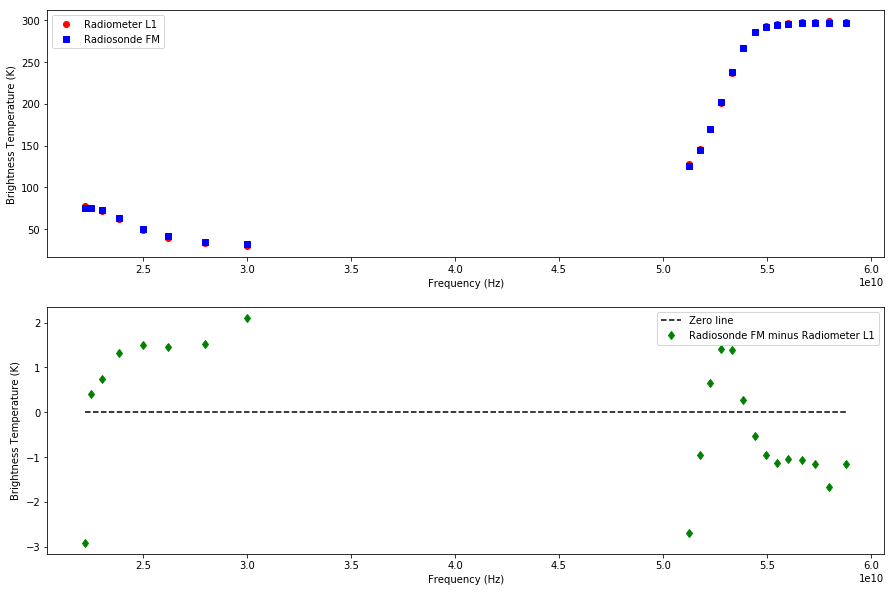

In [36]:
# Compare brightness temperatures from the simulation with the observations. 
plt.figure()

plt.subplot(2,1,1)
plt.plot(radmtr_channels, Tb_radmtr, 'ro', radmtr_channels, Tb_radsnd, 'bs')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Brightness Temperature (K)')
plt.legend(['Radiometer L1', 'Radiosonde FM'])

plt.subplot(2,1,2)
plt.plot(radmtr_channels, np.zeros(radmtr_channels.shape),'k--',
         radmtr_channels, Tb_radsnd - Tb_radmtr, 'gd')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Brightness Temperature (K)')
plt.legend(['Zero line','Radiosonde FM minus Radiometer L1'])

plt.gcf().set_size_inches(15,10)

In [37]:
# Retrieval results
Retrieval = tp.arts.xml.load("./ClearSky_1D_OEM_retrieval_results.xml")
# Pressure grid for retrieval
p_ret_grid = tp.arts.xml.load('./ClearSky_1D_OEM_retrieval_p_grid.xml')
nRet = p_ret_grid.shape[0]
# Convert the retrieval pressure grid to altitude grid. 
f = sp.interpolate.interp1d(radsnd_P, radsnd_HGT)
z_ret_grid = f(p_ret_grid)

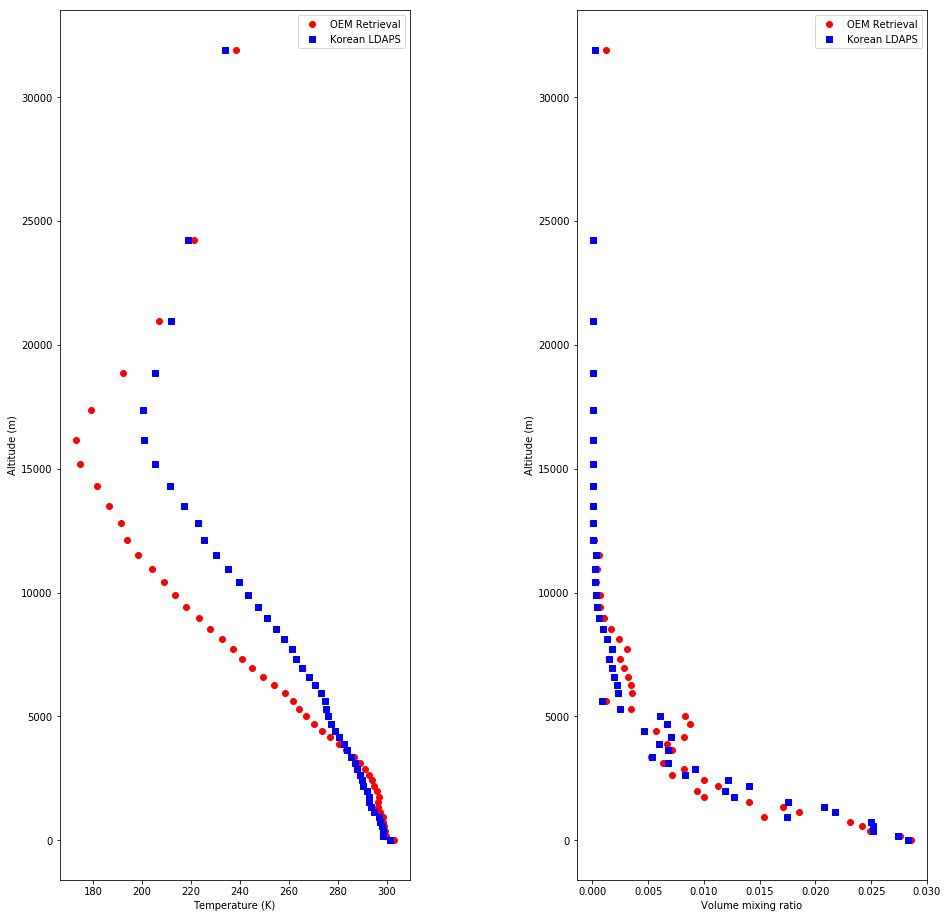

In [38]:
# Plotting the retrieval results 
plt.figure()

plt.subplot(1,2,1)
plt.plot(Retrieval[0:nRet], z_ret_grid, 'ro', radsnd_T, radsnd_HGT, 'bs')
plt.xlabel('Temperature (K)')
plt.ylabel('Altitude (m)')
# plt.ylabel('Pressure (Pa)')
# plt.gca().invert_yaxis()
plt.legend(['OEM Retrieval', 'Korean LDAPS'])

plt.subplot(1,2,2)
plt.plot(Retrieval[nRet:], z_ret_grid, 'ro', radsnd_WaterVMR, radsnd_HGT, 'bs')
plt.xlabel('Volume mixing ratio')
plt.ylabel('Altitude (m)')
# plt.ylabel('Pressure (Pa)')
# plt.gca().invert_yaxis()
plt.legend(['OEM Retrieval', 'Korean LDAPS'])
# plt.gcf().set_size_inches(5,10)

plt.tight_layout()
plt.gcf().set_size_inches(15,15)